##Reinforcement Learning
The next and final topic in this course covers *Reinforcement Learning*. This technique is different than many of the other machine learning techniques we have seen earlier and has many applications in training agents (an AI) to interact with enviornments like games. Rather than feeding our machine learning model millions of examples we let our model come up with its own examples by exploring an enviornemt. The concept is simple. Humans learn by exploring and learning from mistakes and past experiences so let's have our computer do the same.



##Q-Learning Example
For this example we will use the Q-Learning algorithm to train an agent to navigate a popular enviornment from the [Open AI Gym](https://gym.openai.com/). The Open AI Gym was developed so programmers could practice machine learning using unique enviornments. Intersting fact, Elon Musk is one of the founders of OpenAI!

Let's start by looking at what Open AI Gym is.

In [1]:
!pip install --upgrade gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827729 sha256=170fe90701a9b20d4b81e39fe7e83e4e8534fca9397a153bd3c89e09bb1f5e90
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [2]:
import gym   # all you have to do to import and use open ai gym!

Once you import gym you can load an enviornment using the line ```gym.make("enviornment")```.

In [3]:
env = gym.make('FrozenLake-v1',render_mode="rgb_array")  # we are going to use the FrozenLake enviornment

There are a few other commands that can be used to interact and get information about the enviornment.

In [4]:
print(env.observation_space.n)   # get number of states
print(env.action_space.n)   # get number of actions

16
4


In [5]:
env.reset()  # reset enviornment to default state

(0, {'prob': 1})

In [6]:
action = env.action_space.sample()  # get a random action

In [8]:
new_state, reward,terminated, done, info = env.step(action)  # take action, notice it returns information about the action

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
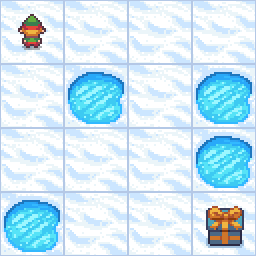

In [9]:
env.render()   # render the GUI for the enviornment

###Frozen Lake Enviornment
Now that we have a basic understanding of how the gym enviornment works it's time to discuss the specific problem we will be solving.

The enviornment we loaded above ```FrozenLake-v0``` is one of the simplest enviornments in Open AI Gym. The goal of the agent is to navigate a frozen lake and find the Goal without falling through the ice (render the enviornment above to see an example).

There are:
- 16 states (one for each square)
- 4 possible actions (LEFT, RIGHT, DOWN, UP)
- 4 different types of blocks (F: frozen, H: hole, S: start, G: goal)



###Building the Q-Table
The first thing we need to do is build an empty Q-Table that we can use to store and update our values.

In [10]:
import gym
import numpy as np
import time

env = gym.make('FrozenLake-v1')
STATES = env.observation_space.n
ACTIONS = env.action_space.n

In [11]:
Q = np.zeros((STATES, ACTIONS))  # create a matrix with all 0 values
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

###Constants
As we discussed we need to define some constants that will be used to update our Q-Table and tell our agent when to stop training.

In [12]:
EPISODES = 2000 # how many times to run the enviornment from the beginning
MAX_STEPS = 100  # max number of steps allowed for each run of enviornment

LEARNING_RATE = 0.81  # learning rate
GAMMA = 0.96

###Picking an Action
Remember that we can pick an action using one of two methods:
1. Randomly picking a valid action
2. Using the current Q-Table to find the best action.

Here we will define a new value $\epsilon$ that will tell us the probabillity of selecting a random action. This value will start off very high and slowly decrease as the agent learns more about the enviornment.

In [13]:
epsilon = 0.9  # start with a 90% chance of picking a random action

# code to pick action
if np.random.uniform(0, 1) < epsilon:  # we will check if a randomly selected value is less than epsilon.
    action = env.action_space.sample()  # take random action
else:
    action = np.argmax(Q[state, :])  # use Q table to pick best action based on current values

###Updating Q Values
The code below implements the formula discussed above.

In [23]:
Q[state, action] = Q[state, action] + LEARNING_RATE * (reward + GAMMA * np.max(Q[new_state, :]) - Q[state, action])

NameError: name 'state' is not defined

###Putting it Together
Now that we know how to do some basic things we can combine these together to create our Q-Learning algorithm,

In [31]:
import gym
import numpy as np
import time

env = gym.make('FrozenLake-v1', is_slippery=False)
STATES = env.observation_space.n
ACTIONS = env.action_space.n

Q = np.zeros((STATES, ACTIONS))

EPISODES = 1500 # how many times to run the enviornment from the beginning
MAX_STEPS = 100  # max number of steps allowed for each run of enviornment

LEARNING_RATE = 0.9  # learning rate
GAMMA = 0.95

RENDER = False # if you want to see training set to true

epsilon = 0.9


In [33]:
rewards = []
for episode in range(EPISODES):

  state,_ = env.reset()
  total_reward = 0
  for _ in range(MAX_STEPS):

    if RENDER:
      env.render()

    if np.random.uniform(0, 1) < epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(Q[state, :])

    next_state, reward, terminated, truncated, _ = env.step(action)


    Q[state, action] = Q[state, action] + LEARNING_RATE * (reward + GAMMA * np.max(Q[next_state, :]) - Q[state, action])

    state = next_state
    total_reward += reward

    if terminated or truncated:
      rewards.append(reward)
      epsilon -= 0.001
      break  # reached goal

print(Q)
print(f"Average reward: {sum(rewards)/len(rewards)}:")
# and now we can see our Q values!

[[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.77378063 0.77378077]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]
Average reward: 0.6913333333333334:


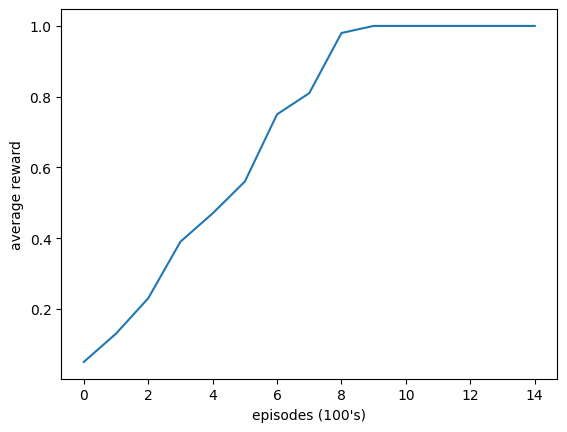

In [34]:
# we can plot the training progress and see how the agent improved
import matplotlib.pyplot as plt

def get_average(values):
  return sum(values)/len(values)

avg_rewards = []
for i in range(0, len(rewards), 100):
  avg_rewards.append(get_average(rewards[i:i+100]))

plt.plot(avg_rewards)
plt.ylabel('average reward')
plt.xlabel('episodes (100\'s)')
plt.show()